In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
import sys
sys.path.append("..")
from util.oneDTravelWave import oneDTravelWave
from scipy.optimize import least_squares
from scipy.io import loadmat
import matplotlib as mpl

In [100]:
def residual(paras, X, Y,tao,delta_x,delta_t_integration, delta_t_frame):
    """
    paras[0]: ypsilon
    paras[1]: mass
    paras[2]: gamma
    """
    ypsilon = paras[0]
    gamma = paras[1]
    mass = paras[2]
    shape = Y.shape
    predict_interval = shape[2]
    prediction = oneDTravelWave(X, predict_interval,gamma, mass, ypsilon,tao, delta_x,delta_t_integration,delta_t_frame)
    #error = np.mean(np.square(Y-prediction))
    return np.reshape(Y-prediction,(-1))
    
def get_data(phase_fields, ids, predict_interval):
    shape = phase_fields.shape
    X = np.zeros((len(ids),shape[0]))
    Y = np.zeros((len(ids),shape[0],predict_interval))
    for i in ids:
        X[i,:]= phase_fields[:,i]
        Y[i,:,:] = phase_fields[:,(i+1):(i+1+predict_interval)]
    #return np.array(X), np.swapaxes(np.array(Y),1,2)
    return X, Y

In [101]:
data = loadmat('../data/phase_field_oneD_simulation.mat')

In [102]:
data['x'].shape

(1, 500)

In [103]:
data['t'].shape

(500, 1)

In [104]:
data['usol'].shape

(500, 500)

In [105]:
x = np.squeeze(data['x'])
t = np.squeeze(data['t'])
phase_fields = data['usol'][:,:100]

In [106]:
predict_interval = 64
shape = phase_fields.shape
ids = np.arange(shape[1]-predict_interval)

In [107]:
X,Y = get_data(phase_fields,ids,predict_interval)

In [108]:
X.shape

(36, 500)

In [109]:
Y.shape

(36, 500, 64)

In [110]:
tao = 1
delta_x = x[1]-x[0]
delta_t_integration = 0.02
delta_t_frame = 0.02
opt = least_squares(residual,[20,2,-0.4],args=[X, Y, tao, delta_x, delta_t_integration, delta_t_frame], ftol=1e-10, xtol=1e-10,)

In [111]:
opt

 active_mask: array([0., 0., 0.])
        cost: 1.8841139845773845e-22
         fun: array([1.56784308e-14, 2.60173827e-14, 3.36675132e-14, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])
        grad: array([ 1.53469655e-13, -7.43860739e-11,  4.95881628e-10])
         jac: array([[-1.13983871e-05,  1.68774977e-04, -3.50023853e-04],
       [-1.91892963e-05,  3.34008599e-04, -6.92648813e-04],
       [-2.51498539e-05,  4.95299002e-04, -1.02700759e-03],
       ...,
       [ 1.49011612e-09, -6.70552259e-08, -1.71363354e-07],
       [ 1.49011612e-09, -6.70552259e-08, -1.78813934e-07],
       [ 1.49011612e-09, -6.70552259e-08, -1.78813934e-07]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 5
        njev: 5
  optimality: 4.958816279847351e-10
      status: 1
     success: True
           x: array([10. ,  1. , -0.4])

In [112]:
prediction = oneDTravelWave(X[0:1,:], predict_interval=predict_interval,ypsilon=opt.x[0], gamma=opt.x[1],
                   mass=opt.x[2], delta_t_integration=delta_t_integration, delta_t_frame=delta_t_frame,delta_x=x[1]-x[0])

In [113]:
prediction.shape

(1, 500, 64)

In [114]:
phase_fields.shape

(500, 100)

(0, 200)

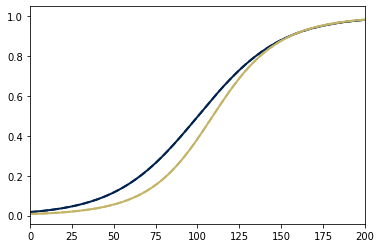

In [115]:
cmap = mpl.cm.cividis
step = 50
for i in range(0,predict_interval, step):
    plt.plot(prediction[0,:,i],linestyle='--',color=cmap(i / float(predict_interval)),linewidth=2)
    plt.plot(phase_fields[:,i+1],linestyle='-',color=cmap(i / float(predict_interval)),linewidth=2)
plt.xlim(0,200)
#plt.legend()